## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Concluding](#conclusions)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [5]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` Distribution of how many articles a user interacts with in the dataset.  We provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [6]:
user_count=[]
for user in df.email.unique():
    user_count.append((user,df[df.email==user].shape[0]))

In [7]:
user_count_df=pd.DataFrame(user_count)
user_count_df.columns=['user','interaction_count']

Text(0.5, 1.0, 'Number of interactions for each user index')

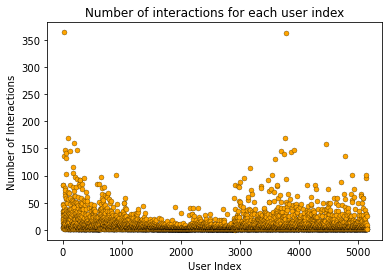

In [8]:
plt.scatter(user_count_df.index,user_count_df.interaction_count,s=25,color='orange',edgecolors='black',lw=0.25)
plt.xlabel('User Index')
plt.ylabel('Number of Interactions')
plt.title('Number of interactions for each user index')

We see that the number of interactions for some users can peak at around 350. But it is seen for most of the users that the number of viewed articles are under 50.

In [9]:
median_val = user_count_df.interaction_count.median() # 50% of individuals interact with median_val number of articles or fewer.
max_views_by_user = user_count_df.interaction_count.max() # The maximum number of user-article interactions by any 1 user is max_views_by_user.

`2.` We proceed by removing duplicate articles from the **df_content** dataframe.  

In [7]:
# Find and explore duplicate articles
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id',inplace=True)

In [8]:
# reset indices
df_content.reset_index(drop=True,inplace=True)

`3.` We provide:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [9]:
# dropping null values in user_count_df 
user_count_df.dropna(inplace=True)

In [10]:
unique_articles = df.article_id.drop_duplicates().shape[0] # The number of unique articles that have at least one interaction
total_articles = len(df_content.article_id.unique()) # The number of unique articles on the IBM platform
unique_users = len(user_count_df.user.unique())  # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` We find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [11]:
unique_ids, reps = np.unique(df.article_id.values,return_counts=True)
article_interaction = pd.DataFrame({'article_id': unique_ids,'interaction_number': reps})

In [12]:
most_viewed_article_id = article_interaction[article_interaction.interaction_number==article_interaction.interaction_number.max()].article_id.values[0] # The most viewed article in the dataset as a string with one value following the decimal
max_views = article_interaction[article_interaction.article_id==most_viewed_article_id].interaction_number.values[0] # The most viewed article in the dataset was viewed how many times?

In [13]:
most_viewed_article_id=str(most_viewed_article_id)

In [14]:

# Cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` We provide the function below to return the **n** top articles ordered with most interactions as the top. 

In [16]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # building a new dataframe based on number of interactions with articles
    unique_ids, reps = np.unique(df.article_id.values,return_counts=True)
    article_interaction = pd.DataFrame({'article_id': unique_ids,'interaction_number': reps})
    
    # sort article ids based on interaction numbers as descending in the newly generated dataframe
    sorted_interaction = article_interaction.sort_values('interaction_number',ascending=False)
    
    # grab n top articles based on n top list of article ids in sorted newly generated dataframe
    chosen_ids = sorted_interaction.iloc[:n,:].article_id.values
    top_articles = list(df[df.article_id.isin(chosen_ids)].title.unique())
    
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # building a new dataframe based on number of interactions with articles
    unique_ids, reps = np.unique(df.article_id.values,return_counts=True)
    article_interaction = pd.DataFrame({'article_id': unique_ids,'interaction_number': reps})
    
    # sort article ids based on interaction numbers as descending in the newly generated dataframe
    sorted_interaction = article_interaction.sort_values('interaction_number',ascending=False)
    
    # grab n top articles based on n top list of article ids in sorted newly generated dataframe
    top_articles = list(sorted_interaction.iloc[:n,:].article_id)
    
 
    return top_articles # Return the top article ids

In [17]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` We provide the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then we place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then we place a zero where the user-row meets for that article-column**. 


In [19]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # building a matrix with users as the index and articles as the column
    user_item = pd.DataFrame(data=0,columns=df.article_id.unique(),index=df.user_id.unique())
    
    # checking df dataframe for each row and change NaN to 1 for specific article id relevant to the user id in df
    for user, article in zip(df.user_id,df.article_id):
        user_item.loc[user,article]=1
    
    return user_item 

user_item = create_user_item_matrix(df)

`2.` We provide the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

In [21]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    ordered_vec - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity_vec = pd.DataFrame(data=0,index=[user_id],columns=user_item.index.values)
    similarity_vec.loc[user_id,:]=np.dot(user_item.loc[user_id,:],user_item.T)

    # sort by similarity excluding the specified user_id
    ordered_vec = similarity_vec.loc[user_id,:].sort_values(ascending=False).index.values[1:]

       
    return ordered_vec # return a list of the users in order from most to least similar
        

In [22]:
# This is a spot check of this function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933   23 3782  203 4459 3870  131 4201   46 5041]
The 5 most similar users to user 3933 are: [3933   23 3782  203 4459]
The 3 most similar users to user 46 are: [4201 3782   23]


`3.` Now that we have a function that provides the most similar users to each user, we want to use these users to find articles we can recommend.  We provide the functions below to return the articles we would recommend to each user. 

In [23]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # elicit names of the articles based on their ids
    article_names = list(df[df.article_id.isin(list(map(float,article_ids)))].title.unique())
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # elicit the ids relevant to the articles that specified user_id has interaction with
    article_ids = list(user_item.loc[user_id,user_item.loc[user_id,:]==1].index.values)
    
    # map each float value to a string value
    article_ids = list(map(str,article_ids))
    
    # elicit the names relevant to article ids
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recomms - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # find users that are most similar to the specified user
    similar_users = find_similar_users(user_id)
    
    # start by assigning an empty list to the list of recommendations
    recomms=[]
    
    # find the ids and names of the articles that specified user had interaction with
    ids_user, names_user = get_user_articles(user_id)
    
    # loop through the most similar users to the specified user
    for user in similar_users:
        
        # get ids and names of the articles for each user through the loop
        ids, names = get_user_articles(user)
        
        # check if article is the same as what specified user in argument had interaction with
        for idd in ids:
            
            # if user_id had no interaction with article and we have not reached the max number 
            # of recommendations, name of article will be appended to the list of recomms
            if (idd not in ids_user) and len(recomms)<m:
                recomms.append(idd)
                
                # eliminate duplicates using set after appending new article
                recomms=list(set(recomms))
        
        # check if max number of recomms is met
        if len(recomms)==m:
            break
    
    
    return recomms # return the recommendations for this user_id    

In [24]:
# Check Results
get_article_names(user_user_recs(2000, 10)) # Return 10 recommendations for user 1

['insights from new york car accident reports',
 'neural language modeling from scratch (part 1)',
 '15 page tutorial for r',
 "a beginner's guide to variational methods",
 'total population by country',
 'the pandas data analysis library',
 'how to map usa rivers using ggplot2',
 'how to write the first for loop in r',
 '10 essential algorithms for machine learning engineers',
 'this week in data science (april 25, 2017)']

In [ ]:
# Test our functions here 
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - we choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, we choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be what would be obtained from the **top_articles** function we wrote earlier.

In [26]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id (index) - is a neighbor user_id
                    similarity (column) - measure of the similarity of each user to the provided user_id
                    num_interactions (column) - the number of articles viewed by the user - if a user has
                    neoghbors with the same closeness, one with higher total interactions will be chosen 
                    for recommendation
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # find the list of neighbors which is sorted based on highest closeness
    neighbor_ids = find_similar_users(user_id)
    
    # consider two empty arrays for similarity and total interactions for each neighbor
    similarity=[]
    total_interaction=[]
    
    # loop through neighbors to find and append similarity and total interaction using user_item matrix
    for neighbor in neighbor_ids:
        
        # append similarity and total interaction for each neighbor
        similarity.append(np.dot(user_item.loc[user_id,:],user_item.T.loc[:,neighbor]))
        total_interaction.append(np.dot(user_item.loc[neighbor,:],user_item.T.loc[:,neighbor]))
        
    # generate a dictionary including data for similarity and total interaction for each neighbor
    data={'similarity': similarity, 'total_interaction':  total_interaction}
    
    # generate a dataframe based on elicited data
    neighbors_df = pd.DataFrame(data=data,index=neighbor_ids)
    
    # sort dataframe first based on similarity and then based on total interactions
    neighbors_df = neighbors_df.sort_values(['similarity','total_interaction'],ascending=False)
    
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # generate neighbors dataframe which is sorted based on similarity and totl interactions
    neighbor_df = get_top_sorted_users(user_id)
    
    # start by assigning an empty list to the list of recommendations
    recomms_names=[]
    recommes_ids=[]
    
    # find the ids and names of the articles that specified user had interaction with
    ids_user, names_user = get_user_articles(user_id)
    
    # loop through the most similar users to the specified user within neighbor dataframe
    for user in neighbor_df.index.values:
        
        # get ids and names of the articles for each user through the loop
        ids, names = get_user_articles(user)
        
        # check if article is the same as what specified user in argument had interaction with
        for idd in ids:
            
            # if user_id had no interaction with article and we have not reached the max number 
            # of recommendations, name of article will be appended to the list of recomms
            if (idd not in ids_user) and len(recommes_ids)<m:
                recommes_ids.append(idd)
                recomms_names.append(df[df.article_id==float(idd)].title.unique()[0])
                
                # eliminate duplicates using set after appending new article
                recommes_ids=list(set(recommes_ids))
                recomms_names=list(set(recomms_names))
        
        # check if max number of recomms is met
        if len(recommes_ids)==m:
            break
    
    return recommes_ids, recomms_names

In [27]:
# Quick spot check 
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1429.0', '14.0', '1162.0', '1164.0', '1314.0', '1332.0', '12.0', '1432.0', '1276.0', '1338.0']

The top 10 recommendations for user 20 are the following article names:
['healthcare python streaming application demo', 'intents & examples for ibm watson conversation', 'analyze open data sets with pandas dataframes', 'use deep learning for image classification', 'visualize data with the matplotlib library', 'analyze energy consumption in buildings', 'got zip code data? prep it for analytics. – ibm watson data lab – medium', 'deploy your python model as a restful api', 'ml optimization using cognitive assistant', 'timeseries data analysis of iot events by using jupyter notebook']


`5.` We use functions from above to correctly fill in below.  

In [28]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).index.values[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).index.values[10] # Find the 10th most similar user to user 131

`7.` Using our existing functions, we provide the top 10 recommended articles we would provide for the a new user below. 

In [49]:
new_user = '0.0'

# What would our recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# We provide a list of the top 10 article ids you would give to 
new_user_recs = list(df[df.title.isin(get_top_articles(10, df=df))].article_id.unique().astype('str')) # Your recommendations here



In [ ]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, we will use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` We have already created a **user_item** matrix above in **section 1** of **Part III** above.  This first section here will just require that we run the cells to get things set up for the rest of **Part V** of this notebook. 

In [52]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [53]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, we can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  We use the cell to perform SVD. 

In [54]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

**Here the matrix to decompose does not have any NaN values, so we can use SVD instead of FunkSVD to find u,s, and vt contributing matrices.**

`3.` Running the below cell, we can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  We run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

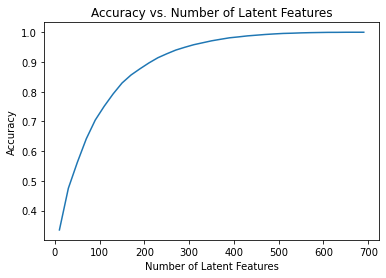

In [132]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

In [60]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train=create_user_item_matrix(df_train)
    user_item_test=create_user_item_matrix(df_test)
    test_idx=list(user_item_test.index.values)
    test_arts=list(user_item_test.columns.values)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [102]:
# we note that we can only predict interaction with articles for the test user ids that are present in training dataset
user_item_train[user_item_train.index.isin(test_idx)].shape[0]

20

`5.` Now we use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then we find the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. We use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [122]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

# rows from user_item_test that can be predicted using the user_item_train, otherwise we cannot predict article interaction
test_index_prediction = list(user_item_train[user_item_train.index.isin(test_idx)].index)

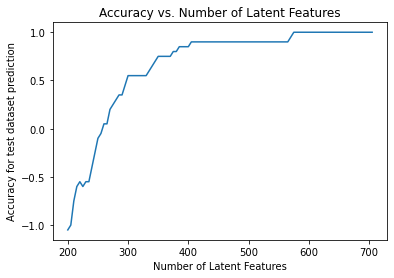

In [158]:
# Cells to see how well you can use the training 
# Decomposition to predict on test data

num_latent_feats = np.arange(200,700+10,5)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_estt = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    
    # compute error for all predictions as compared to actual value
    diffs = np.subtract(user_item_train, user_item_estt)
    
    # total errors for test dataset predictions and keep track of them (only test data are considered for error calculation)
    err = np.sum(np.sum(np.abs(diffs[diffs.index.isin(test_index_prediction)])))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/len(test_index_prediction));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy for test dataset prediction');
plt.title('Accuracy vs. Number of Latent Features');

**Plot shows that predictions based on training data can well adapt actual values for test data if we increase the number of latent features to more than 400. for the latent features less than almost 280, the result would be negative and not acceptable, which is not seen for the training data plot in previous question. So we now know that a high number of latent features (more than 400) can eliminate under-fitting in this problem.**

**Here we have many users in test data who do not have any relevant information in training data. So one way to improve our work is to use content-based recommendation for test data and recommend articles based on the content of the articles that test users already have interacted with. It means that we have to consider hybrid approach for this problem to have a better result overall. Another way is to increase amount of data to improve accuracy of the results.**